# Object detection with Keras and TS

- Documentation : https://www.tensorflow.org/hub/tutorials/object_detection?hl=fr

## Setup

In [6]:
%pip install -q tflite-model-maker
%pip install -q tflite-support
%pip install opencv-python-headless==4.5.2.52
!pip3 install pycocotools



try:
# pylint: disable=g-import-not-at-top
  from pycocotools.coco import COCO
  from pycocotools.cocoeval import COCOeval
# pylint: enable=g-import-not-at-top
except ImportError:
  print('Erreur')


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
import os

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

## Chargement du jeu de données

In [8]:
train_folder = 'datasets/dataset.voc/train'
val_folder = 'datasets/dataset.voc/valid'
test_folder = 'datasets/dataset.voc/test'

# These images are used to train the object detection model to recognize plastic and can
train_data = object_detector.DataLoader.from_pascal_voc(
    train_folder,
    train_folder,
    ['plastique','canette', 'plastic']
)

train_data

# These images are used to evaluate the model. 
# These are images that the model didn't see during the training process. You'll use them to decide when you should stop the training, to avoid overfitting.
val_data = object_detector.DataLoader.from_pascal_voc(
    val_folder,
    val_folder,
    # label_map={1: "plastique", 2: "canette"}
    ['plastique','canette', 'plastic']
)

# These images are used to evaluate the final model performance.
test_data = object_detector.DataLoader.from_pascal_voc(
    test_folder,
    test_folder,
    ['plastique','canette', 'plastic']
)

## Mise en cache des données

In [9]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

## Selection du modèle

In [10]:
# Liste des modèles possibles : https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/model_spec
# spec = model_spec.get('mobilenet_v2')
# spec = model_spec.get('efficientdet_lite4')

verbose=1
tflite_max_detections=3

spec = model_spec.get('efficientdet_lite3')
spec.tflite_max_detections=tflite_max_detections
spec.verbose=verbose


2024-04-16 02:21:56.550489: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-16 02:21:56.550533: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-16 02:21:56.550552: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-R17EPGM): /proc/driver/nvidia/version does not exist
2024-04-16 02:21:56.554242: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Entrainement du modèle

In [11]:
# Entraîner entièrement le modèle (fine-tuning) ?
train_whole_model=True
epochs=80
batch_size=10
model = object_detector.create(train_data, 
                               validation_data=val_data,
                               model_spec=spec, 
                               train_whole_model=train_whole_model,
                               epochs=epochs,
                               batch_size=batch_size
                               )


Epoch 1/80


2024-04-16 02:22:14.052061: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - ETA: 0s - det_loss: 1.4041 - cls_loss: 0.8352 - box_loss: 0.0114 - reg_l2_loss: 0.0928 - loss: 1.4968 - learning_rate: 0.0071 - gradient_norm: 4.7694

2024-04-16 02:31:23.466394: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 565s 5s/step - det_loss: 1.4032 - cls_loss: 0.8339 - box_loss: 0.0114 - reg_l2_loss: 0.0928 - loss: 1.4960 - learning_rate: 0.0071 - gradient_norm: 4.8098 - val_det_loss: 1.1951 - val_cls_loss: 0.7302 - val_box_loss: 0.0093 - val_reg_l2_loss: 0.0929 - val_loss: 1.2880
Epoch 2/80
99/99 [==============================] - ETA: 0s - det_loss: 0.9001 - cls_loss: 0.5440 - box_loss: 0.0071 - reg_l2_loss: 0.0931 - loss: 0.9932 - learning_rate: 0.0062 - gradient_norm: 5.9531

2024-04-16 02:40:15.266963: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 523s 5s/step - det_loss: 0.8989 - cls_loss: 0.5430 - box_loss: 0.0071 - reg_l2_loss: 0.0931 - loss: 0.9919 - learning_rate: 0.0062 - gradient_norm: 5.9675 - val_det_loss: 0.8759 - val_cls_loss: 0.4814 - val_box_loss: 0.0079 - val_reg_l2_loss: 0.0932 - val_loss: 0.9691
Epoch 3/80
99/99 [==============================] - ETA: 0s - det_loss: 0.7891 - cls_loss: 0.4814 - box_loss: 0.0062 - reg_l2_loss: 0.0933 - loss: 0.8824 - learning_rate: 0.0062 - gradient_norm: 6.1059

2024-04-16 02:49:10.545348: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 535s 5s/step - det_loss: 0.7895 - cls_loss: 0.4819 - box_loss: 0.0062 - reg_l2_loss: 0.0933 - loss: 0.8828 - learning_rate: 0.0062 - gradient_norm: 6.1246 - val_det_loss: 0.8428 - val_cls_loss: 0.5358 - val_box_loss: 0.0061 - val_reg_l2_loss: 0.0935 - val_loss: 0.9362
Epoch 4/80
99/99 [==============================] - ETA: 0s - det_loss: 0.7161 - cls_loss: 0.4387 - box_loss: 0.0055 - reg_l2_loss: 0.0936 - loss: 0.8097 - learning_rate: 0.0062 - gradient_norm: 6.4730

2024-04-16 02:57:17.615470: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 487s 5s/step - det_loss: 0.7167 - cls_loss: 0.4393 - box_loss: 0.0055 - reg_l2_loss: 0.0936 - loss: 0.8103 - learning_rate: 0.0062 - gradient_norm: 6.4802 - val_det_loss: 1.0237 - val_cls_loss: 0.5577 - val_box_loss: 0.0093 - val_reg_l2_loss: 0.0938 - val_loss: 1.1175
Epoch 5/80
99/99 [==============================] - ETA: 0s - det_loss: 0.6207 - cls_loss: 0.3820 - box_loss: 0.0048 - reg_l2_loss: 0.0939 - loss: 0.7146 - learning_rate: 0.0062 - gradient_norm: 5.3103

2024-04-16 03:05:19.815808: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 494s 5s/step - det_loss: 0.6188 - cls_loss: 0.3804 - box_loss: 0.0048 - reg_l2_loss: 0.0939 - loss: 0.7126 - learning_rate: 0.0062 - gradient_norm: 5.2842 - val_det_loss: 0.8094 - val_cls_loss: 0.4275 - val_box_loss: 0.0076 - val_reg_l2_loss: 0.0940 - val_loss: 0.9034
Epoch 6/80
99/99 [==============================] - ETA: 0s - det_loss: 0.6072 - cls_loss: 0.3726 - box_loss: 0.0047 - reg_l2_loss: 0.0941 - loss: 0.7013 - learning_rate: 0.0062 - gradient_norm: 5.4776

2024-04-16 03:13:21.197537: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 470s 5s/step - det_loss: 0.6065 - cls_loss: 0.3727 - box_loss: 0.0047 - reg_l2_loss: 0.0941 - loss: 0.7006 - learning_rate: 0.0062 - gradient_norm: 5.4754 - val_det_loss: 0.5657 - val_cls_loss: 0.3187 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0942 - val_loss: 0.6599
Epoch 7/80
99/99 [==============================] - ETA: 0s - det_loss: 0.6031 - cls_loss: 0.3690 - box_loss: 0.0047 - reg_l2_loss: 0.0943 - loss: 0.6973 - learning_rate: 0.0061 - gradient_norm: 4.9634

2024-04-16 03:21:07.895475: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 467s 5s/step - det_loss: 0.6018 - cls_loss: 0.3681 - box_loss: 0.0047 - reg_l2_loss: 0.0943 - loss: 0.6961 - learning_rate: 0.0061 - gradient_norm: 4.9469 - val_det_loss: 0.6874 - val_cls_loss: 0.4255 - val_box_loss: 0.0052 - val_reg_l2_loss: 0.0944 - val_loss: 0.7818
Epoch 8/80
99/99 [==============================] - ETA: 0s - det_loss: 0.5409 - cls_loss: 0.3368 - box_loss: 0.0041 - reg_l2_loss: 0.0944 - loss: 0.6353 - learning_rate: 0.0061 - gradient_norm: 4.6086

2024-04-16 03:28:57.009546: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 470s 5s/step - det_loss: 0.5414 - cls_loss: 0.3370 - box_loss: 0.0041 - reg_l2_loss: 0.0944 - loss: 0.6358 - learning_rate: 0.0061 - gradient_norm: 4.6348 - val_det_loss: 0.6094 - val_cls_loss: 0.3435 - val_box_loss: 0.0053 - val_reg_l2_loss: 0.0945 - val_loss: 0.7039
Epoch 9/80
99/99 [==============================] - ETA: 0s - det_loss: 0.5500 - cls_loss: 0.3378 - box_loss: 0.0042 - reg_l2_loss: 0.0946 - loss: 0.6446 - learning_rate: 0.0061 - gradient_norm: 4.9281

2024-04-16 03:36:32.277376: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 455s 5s/step - det_loss: 0.5504 - cls_loss: 0.3377 - box_loss: 0.0043 - reg_l2_loss: 0.0946 - loss: 0.6450 - learning_rate: 0.0061 - gradient_norm: 4.9730 - val_det_loss: 0.6866 - val_cls_loss: 0.3702 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.0947 - val_loss: 0.7813
Epoch 10/80
99/99 [==============================] - ETA: 0s - det_loss: 0.5525 - cls_loss: 0.3505 - box_loss: 0.0040 - reg_l2_loss: 0.0947 - loss: 0.6473 - learning_rate: 0.0060 - gradient_norm: 4.9607

2024-04-16 03:44:07.018218: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 460s 5s/step - det_loss: 0.5518 - cls_loss: 0.3497 - box_loss: 0.0040 - reg_l2_loss: 0.0947 - loss: 0.6466 - learning_rate: 0.0060 - gradient_norm: 4.9425 - val_det_loss: 0.7136 - val_cls_loss: 0.4402 - val_box_loss: 0.0055 - val_reg_l2_loss: 0.0948 - val_loss: 0.8084
Epoch 11/80
99/99 [==============================] - ETA: 0s - det_loss: 0.5508 - cls_loss: 0.3447 - box_loss: 0.0041 - reg_l2_loss: 0.0949 - loss: 0.6457 - learning_rate: 0.0060 - gradient_norm: 4.6115

2024-04-16 03:51:46.379036: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 459s 5s/step - det_loss: 0.5513 - cls_loss: 0.3446 - box_loss: 0.0041 - reg_l2_loss: 0.0949 - loss: 0.6462 - learning_rate: 0.0060 - gradient_norm: 4.6107 - val_det_loss: 0.6710 - val_cls_loss: 0.4088 - val_box_loss: 0.0052 - val_reg_l2_loss: 0.0950 - val_loss: 0.7660
Epoch 12/80
99/99 [==============================] - ETA: 0s - det_loss: 0.5136 - cls_loss: 0.3227 - box_loss: 0.0038 - reg_l2_loss: 0.0950 - loss: 0.6086 - learning_rate: 0.0059 - gradient_norm: 4.2244

2024-04-16 03:59:42.881569: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 472s 5s/step - det_loss: 0.5125 - cls_loss: 0.3221 - box_loss: 0.0038 - reg_l2_loss: 0.0950 - loss: 0.6075 - learning_rate: 0.0059 - gradient_norm: 4.2103 - val_det_loss: 0.7886 - val_cls_loss: 0.4673 - val_box_loss: 0.0064 - val_reg_l2_loss: 0.0951 - val_loss: 0.8837
Epoch 13/80
99/99 [==============================] - ETA: 0s - det_loss: 0.4982 - cls_loss: 0.3067 - box_loss: 0.0038 - reg_l2_loss: 0.0951 - loss: 0.5933 - learning_rate: 0.0059 - gradient_norm: 3.5232

2024-04-16 04:07:19.870719: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 456s 5s/step - det_loss: 0.4983 - cls_loss: 0.3069 - box_loss: 0.0038 - reg_l2_loss: 0.0951 - loss: 0.5934 - learning_rate: 0.0059 - gradient_norm: 3.5164 - val_det_loss: 0.5224 - val_cls_loss: 0.3175 - val_box_loss: 0.0041 - val_reg_l2_loss: 0.0951 - val_loss: 0.6175
Epoch 14/80
99/99 [==============================] - ETA: 0s - det_loss: 0.4807 - cls_loss: 0.3024 - box_loss: 0.0036 - reg_l2_loss: 0.0951 - loss: 0.5759 - learning_rate: 0.0058 - gradient_norm: 3.6396

2024-04-16 04:14:53.992287: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 454s 5s/step - det_loss: 0.4798 - cls_loss: 0.3012 - box_loss: 0.0036 - reg_l2_loss: 0.0951 - loss: 0.5750 - learning_rate: 0.0058 - gradient_norm: 3.6281 - val_det_loss: 0.5993 - val_cls_loss: 0.3481 - val_box_loss: 0.0050 - val_reg_l2_loss: 0.0952 - val_loss: 0.6944
Epoch 15/80
99/99 [==============================] - ETA: 0s - det_loss: 0.4837 - cls_loss: 0.3068 - box_loss: 0.0035 - reg_l2_loss: 0.0952 - loss: 0.5789 - learning_rate: 0.0057 - gradient_norm: 4.1542

2024-04-16 04:22:29.347693: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 462s 5s/step - det_loss: 0.4825 - cls_loss: 0.3063 - box_loss: 0.0035 - reg_l2_loss: 0.0952 - loss: 0.5777 - learning_rate: 0.0057 - gradient_norm: 4.1636 - val_det_loss: 0.5278 - val_cls_loss: 0.2888 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0953 - val_loss: 0.6231
Epoch 16/80
99/99 [==============================] - ETA: 0s - det_loss: 0.4718 - cls_loss: 0.2892 - box_loss: 0.0037 - reg_l2_loss: 0.0953 - loss: 0.5671 - learning_rate: 0.0057 - gradient_norm: 3.9785

2024-04-16 04:30:08.291951: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 453s 5s/step - det_loss: 0.4726 - cls_loss: 0.2897 - box_loss: 0.0037 - reg_l2_loss: 0.0953 - loss: 0.5679 - learning_rate: 0.0057 - gradient_norm: 3.9956 - val_det_loss: 0.5628 - val_cls_loss: 0.3073 - val_box_loss: 0.0051 - val_reg_l2_loss: 0.0953 - val_loss: 0.6581
Epoch 17/80
99/99 [==============================] - ETA: 0s - det_loss: 0.4783 - cls_loss: 0.3013 - box_loss: 0.0035 - reg_l2_loss: 0.0954 - loss: 0.5737 - learning_rate: 0.0056 - gradient_norm: 4.3813

2024-04-16 04:37:42.828565: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 454s 5s/step - det_loss: 0.4779 - cls_loss: 0.3010 - box_loss: 0.0035 - reg_l2_loss: 0.0954 - loss: 0.5732 - learning_rate: 0.0056 - gradient_norm: 4.3605 - val_det_loss: 0.5540 - val_cls_loss: 0.3476 - val_box_loss: 0.0041 - val_reg_l2_loss: 0.0954 - val_loss: 0.6494
Epoch 18/80
99/99 [==============================] - ETA: 0s - det_loss: 0.4517 - cls_loss: 0.2861 - box_loss: 0.0033 - reg_l2_loss: 0.0955 - loss: 0.5472 - learning_rate: 0.0055 - gradient_norm: 3.9763

2024-04-16 04:45:17.357478: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 455s 5s/step - det_loss: 0.4508 - cls_loss: 0.2855 - box_loss: 0.0033 - reg_l2_loss: 0.0955 - loss: 0.5463 - learning_rate: 0.0055 - gradient_norm: 3.9776 - val_det_loss: 0.4289 - val_cls_loss: 0.2532 - val_box_loss: 0.0035 - val_reg_l2_loss: 0.0955 - val_loss: 0.5244
Epoch 19/80
99/99 [==============================] - ETA: 0s - det_loss: 0.4606 - cls_loss: 0.2775 - box_loss: 0.0037 - reg_l2_loss: 0.0956 - loss: 0.5562 - learning_rate: 0.0054 - gradient_norm: 4.0911

2024-04-16 04:52:53.127300: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 456s 5s/step - det_loss: 0.4594 - cls_loss: 0.2765 - box_loss: 0.0037 - reg_l2_loss: 0.0956 - loss: 0.5550 - learning_rate: 0.0054 - gradient_norm: 4.0748 - val_det_loss: 0.5813 - val_cls_loss: 0.3447 - val_box_loss: 0.0047 - val_reg_l2_loss: 0.0956 - val_loss: 0.6769
Epoch 20/80
99/99 [==============================] - ETA: 0s - det_loss: 0.4252 - cls_loss: 0.2574 - box_loss: 0.0034 - reg_l2_loss: 0.0956 - loss: 0.5208 - learning_rate: 0.0054 - gradient_norm: 3.3268

2024-04-16 05:00:25.660859: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 458s 5s/step - det_loss: 0.4242 - cls_loss: 0.2568 - box_loss: 0.0033 - reg_l2_loss: 0.0956 - loss: 0.5198 - learning_rate: 0.0054 - gradient_norm: 3.3189 - val_det_loss: 0.6712 - val_cls_loss: 0.4170 - val_box_loss: 0.0051 - val_reg_l2_loss: 0.0956 - val_loss: 0.7668
Epoch 21/80
99/99 [==============================] - ETA: 0s - det_loss: 0.4234 - cls_loss: 0.2645 - box_loss: 0.0032 - reg_l2_loss: 0.0956 - loss: 0.5190 - learning_rate: 0.0053 - gradient_norm: 3.5642

2024-04-16 05:08:05.511917: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 454s 5s/step - det_loss: 0.4246 - cls_loss: 0.2653 - box_loss: 0.0032 - reg_l2_loss: 0.0956 - loss: 0.5202 - learning_rate: 0.0053 - gradient_norm: 3.5634 - val_det_loss: 0.5658 - val_cls_loss: 0.3433 - val_box_loss: 0.0044 - val_reg_l2_loss: 0.0957 - val_loss: 0.6614
Epoch 22/80
99/99 [==============================] - ETA: 0s - det_loss: 0.4090 - cls_loss: 0.2578 - box_loss: 0.0030 - reg_l2_loss: 0.0957 - loss: 0.5046 - learning_rate: 0.0052 - gradient_norm: 3.3466

2024-04-16 05:15:36.987439: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 452s 5s/step - det_loss: 0.4088 - cls_loss: 0.2580 - box_loss: 0.0030 - reg_l2_loss: 0.0957 - loss: 0.5045 - learning_rate: 0.0052 - gradient_norm: 3.3758 - val_det_loss: 0.5296 - val_cls_loss: 0.2939 - val_box_loss: 0.0047 - val_reg_l2_loss: 0.0957 - val_loss: 0.6253
Epoch 23/80
99/99 [==============================] - ETA: 0s - det_loss: 0.4175 - cls_loss: 0.2521 - box_loss: 0.0033 - reg_l2_loss: 0.0957 - loss: 0.5133 - learning_rate: 0.0051 - gradient_norm: 3.6457

2024-04-16 05:23:09.040951: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 457s 5s/step - det_loss: 0.4184 - cls_loss: 0.2526 - box_loss: 0.0033 - reg_l2_loss: 0.0957 - loss: 0.5141 - learning_rate: 0.0051 - gradient_norm: 3.6322 - val_det_loss: 0.6853 - val_cls_loss: 0.3979 - val_box_loss: 0.0057 - val_reg_l2_loss: 0.0957 - val_loss: 0.7810
Epoch 24/80
99/99 [==============================] - ETA: 0s - det_loss: 0.4206 - cls_loss: 0.2537 - box_loss: 0.0033 - reg_l2_loss: 0.0958 - loss: 0.5164 - learning_rate: 0.0050 - gradient_norm: 3.6878

2024-04-16 05:30:45.131459: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 451s 5s/step - det_loss: 0.4213 - cls_loss: 0.2544 - box_loss: 0.0033 - reg_l2_loss: 0.0958 - loss: 0.5171 - learning_rate: 0.0050 - gradient_norm: 3.6785 - val_det_loss: 0.6227 - val_cls_loss: 0.3632 - val_box_loss: 0.0052 - val_reg_l2_loss: 0.0958 - val_loss: 0.7185
Epoch 25/80
99/99 [==============================] - ETA: 0s - det_loss: 0.4372 - cls_loss: 0.2726 - box_loss: 0.0033 - reg_l2_loss: 0.0958 - loss: 0.5330 - learning_rate: 0.0049 - gradient_norm: 3.6383

2024-04-16 05:38:16.452805: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 458s 5s/step - det_loss: 0.4363 - cls_loss: 0.2721 - box_loss: 0.0033 - reg_l2_loss: 0.0958 - loss: 0.5321 - learning_rate: 0.0049 - gradient_norm: 3.6286 - val_det_loss: 0.7297 - val_cls_loss: 0.4448 - val_box_loss: 0.0057 - val_reg_l2_loss: 0.0958 - val_loss: 0.8256
Epoch 26/80
99/99 [==============================] - ETA: 0s - det_loss: 0.4073 - cls_loss: 0.2562 - box_loss: 0.0030 - reg_l2_loss: 0.0958 - loss: 0.5031 - learning_rate: 0.0048 - gradient_norm: 3.5907

2024-04-16 05:45:55.596818: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 453s 5s/step - det_loss: 0.4074 - cls_loss: 0.2565 - box_loss: 0.0030 - reg_l2_loss: 0.0958 - loss: 0.5033 - learning_rate: 0.0048 - gradient_norm: 3.5837 - val_det_loss: 0.4784 - val_cls_loss: 0.2884 - val_box_loss: 0.0038 - val_reg_l2_loss: 0.0958 - val_loss: 0.5743
Epoch 27/80
99/99 [==============================] - ETA: 0s - det_loss: 0.3828 - cls_loss: 0.2446 - box_loss: 0.0028 - reg_l2_loss: 0.0959 - loss: 0.4787 - learning_rate: 0.0047 - gradient_norm: 3.1573 

2024-04-16 06:20:50.644546: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 2095s 21s/step - det_loss: 0.3818 - cls_loss: 0.2442 - box_loss: 0.0028 - reg_l2_loss: 0.0959 - loss: 0.4777 - learning_rate: 0.0047 - gradient_norm: 3.1419 - val_det_loss: 0.6729 - val_cls_loss: 0.4208 - val_box_loss: 0.0050 - val_reg_l2_loss: 0.0959 - val_loss: 0.7688
Epoch 28/80
99/99 [==============================] - ETA: 0s - det_loss: 0.4196 - cls_loss: 0.2663 - box_loss: 0.0031 - reg_l2_loss: 0.0959 - loss: 0.5154 - learning_rate: 0.0046 - gradient_norm: 3.6057

2024-04-16 06:28:28.611375: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 458s 5s/step - det_loss: 0.4201 - cls_loss: 0.2663 - box_loss: 0.0031 - reg_l2_loss: 0.0959 - loss: 0.5160 - learning_rate: 0.0046 - gradient_norm: 3.6023 - val_det_loss: 0.5140 - val_cls_loss: 0.3251 - val_box_loss: 0.0038 - val_reg_l2_loss: 0.0959 - val_loss: 0.6099
Epoch 29/80
99/99 [==============================] - ETA: 0s - det_loss: 0.3862 - cls_loss: 0.2448 - box_loss: 0.0028 - reg_l2_loss: 0.0959 - loss: 0.4821 - learning_rate: 0.0044 - gradient_norm: 3.5029

2024-04-16 06:36:01.161386: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 454s 5s/step - det_loss: 0.3857 - cls_loss: 0.2445 - box_loss: 0.0028 - reg_l2_loss: 0.0959 - loss: 0.4816 - learning_rate: 0.0044 - gradient_norm: 3.4962 - val_det_loss: 0.5318 - val_cls_loss: 0.3136 - val_box_loss: 0.0044 - val_reg_l2_loss: 0.0959 - val_loss: 0.6277
Epoch 30/80
99/99 [==============================] - ETA: 0s - det_loss: 0.3811 - cls_loss: 0.2450 - box_loss: 0.0027 - reg_l2_loss: 0.0959 - loss: 0.4770 - learning_rate: 0.0043 - gradient_norm: 3.3156

2024-04-16 06:43:34.072204: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 458s 5s/step - det_loss: 0.3810 - cls_loss: 0.2450 - box_loss: 0.0027 - reg_l2_loss: 0.0959 - loss: 0.4769 - learning_rate: 0.0043 - gradient_norm: 3.3162 - val_det_loss: 0.6100 - val_cls_loss: 0.3454 - val_box_loss: 0.0053 - val_reg_l2_loss: 0.0959 - val_loss: 0.7060
Epoch 31/80
99/99 [==============================] - ETA: 0s - det_loss: 0.3739 - cls_loss: 0.2371 - box_loss: 0.0027 - reg_l2_loss: 0.0959 - loss: 0.4699 - learning_rate: 0.0042 - gradient_norm: 3.3237

2024-04-16 06:51:11.691283: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 452s 5s/step - det_loss: 0.3737 - cls_loss: 0.2370 - box_loss: 0.0027 - reg_l2_loss: 0.0959 - loss: 0.4696 - learning_rate: 0.0042 - gradient_norm: 3.3195 - val_det_loss: 0.5814 - val_cls_loss: 0.3422 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0960 - val_loss: 0.6773
Epoch 32/80
99/99 [==============================] - ETA: 0s - det_loss: 0.3587 - cls_loss: 0.2260 - box_loss: 0.0027 - reg_l2_loss: 0.0960 - loss: 0.4546 - learning_rate: 0.0041 - gradient_norm: 3.1519

2024-04-16 06:58:39.971435: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 448s 5s/step - det_loss: 0.3587 - cls_loss: 0.2255 - box_loss: 0.0027 - reg_l2_loss: 0.0960 - loss: 0.4546 - learning_rate: 0.0041 - gradient_norm: 3.1572 - val_det_loss: 0.4554 - val_cls_loss: 0.2594 - val_box_loss: 0.0039 - val_reg_l2_loss: 0.0960 - val_loss: 0.5514
Epoch 33/80
99/99 [==============================] - ETA: 0s - det_loss: 0.3451 - cls_loss: 0.2159 - box_loss: 0.0026 - reg_l2_loss: 0.0960 - loss: 0.4411 - learning_rate: 0.0040 - gradient_norm: 3.5384

2024-04-16 07:06:10.528313: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 450s 5s/step - det_loss: 0.3450 - cls_loss: 0.2159 - box_loss: 0.0026 - reg_l2_loss: 0.0960 - loss: 0.4410 - learning_rate: 0.0040 - gradient_norm: 3.5815 - val_det_loss: 0.5706 - val_cls_loss: 0.3767 - val_box_loss: 0.0039 - val_reg_l2_loss: 0.0960 - val_loss: 0.6665
Epoch 34/80
99/99 [==============================] - ETA: 0s - det_loss: 0.3454 - cls_loss: 0.2191 - box_loss: 0.0025 - reg_l2_loss: 0.0960 - loss: 0.4414 - learning_rate: 0.0039 - gradient_norm: 3.5855

2024-04-16 07:13:39.936090: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 449s 5s/step - det_loss: 0.3464 - cls_loss: 0.2196 - box_loss: 0.0025 - reg_l2_loss: 0.0960 - loss: 0.4424 - learning_rate: 0.0039 - gradient_norm: 3.5916 - val_det_loss: 0.4664 - val_cls_loss: 0.2615 - val_box_loss: 0.0041 - val_reg_l2_loss: 0.0960 - val_loss: 0.5624
Epoch 35/80
99/99 [==============================] - ETA: 0s - det_loss: 0.3482 - cls_loss: 0.2208 - box_loss: 0.0025 - reg_l2_loss: 0.0960 - loss: 0.4442 - learning_rate: 0.0037 - gradient_norm: 3.2823

2024-04-16 07:21:10.666872: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 457s 5s/step - det_loss: 0.3478 - cls_loss: 0.2207 - box_loss: 0.0025 - reg_l2_loss: 0.0960 - loss: 0.4439 - learning_rate: 0.0037 - gradient_norm: 3.2783 - val_det_loss: 0.4935 - val_cls_loss: 0.2842 - val_box_loss: 0.0042 - val_reg_l2_loss: 0.0960 - val_loss: 0.5895
Epoch 36/80
99/99 [==============================] - ETA: 0s - det_loss: 0.3462 - cls_loss: 0.2204 - box_loss: 0.0025 - reg_l2_loss: 0.0960 - loss: 0.4423 - learning_rate: 0.0036 - gradient_norm: 3.4274

2024-04-16 07:28:47.962293: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 452s 5s/step - det_loss: 0.3469 - cls_loss: 0.2209 - box_loss: 0.0025 - reg_l2_loss: 0.0960 - loss: 0.4429 - learning_rate: 0.0036 - gradient_norm: 3.4931 - val_det_loss: 0.4147 - val_cls_loss: 0.2313 - val_box_loss: 0.0037 - val_reg_l2_loss: 0.0960 - val_loss: 0.5107
Epoch 37/80
99/99 [==============================] - ETA: 0s - det_loss: 0.3421 - cls_loss: 0.2198 - box_loss: 0.0024 - reg_l2_loss: 0.0960 - loss: 0.4382 - learning_rate: 0.0035 - gradient_norm: 3.2342

2024-04-16 07:36:19.563840: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 451s 5s/step - det_loss: 0.3415 - cls_loss: 0.2195 - box_loss: 0.0024 - reg_l2_loss: 0.0960 - loss: 0.4375 - learning_rate: 0.0035 - gradient_norm: 3.2382 - val_det_loss: 0.3989 - val_cls_loss: 0.2144 - val_box_loss: 0.0037 - val_reg_l2_loss: 0.0960 - val_loss: 0.4949
Epoch 38/80
99/99 [==============================] - ETA: 0s - det_loss: 0.3455 - cls_loss: 0.2193 - box_loss: 0.0025 - reg_l2_loss: 0.0960 - loss: 0.4415 - learning_rate: 0.0034 - gradient_norm: 3.5748

2024-04-16 07:44:14.662037: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 475s 5s/step - det_loss: 0.3448 - cls_loss: 0.2189 - box_loss: 0.0025 - reg_l2_loss: 0.0960 - loss: 0.4408 - learning_rate: 0.0034 - gradient_norm: 3.5887 - val_det_loss: 0.5332 - val_cls_loss: 0.3239 - val_box_loss: 0.0042 - val_reg_l2_loss: 0.0960 - val_loss: 0.6292
Epoch 39/80
99/99 [==============================] - ETA: 0s - det_loss: 0.3380 - cls_loss: 0.2147 - box_loss: 0.0025 - reg_l2_loss: 0.0960 - loss: 0.4340 - learning_rate: 0.0032 - gradient_norm: 3.4014

2024-04-16 07:51:51.395081: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 458s 5s/step - det_loss: 0.3373 - cls_loss: 0.2143 - box_loss: 0.0025 - reg_l2_loss: 0.0960 - loss: 0.4333 - learning_rate: 0.0032 - gradient_norm: 3.3860 - val_det_loss: 0.5314 - val_cls_loss: 0.3269 - val_box_loss: 0.0041 - val_reg_l2_loss: 0.0960 - val_loss: 0.6274
Epoch 40/80
99/99 [==============================] - ETA: 0s - det_loss: 0.3298 - cls_loss: 0.2121 - box_loss: 0.0024 - reg_l2_loss: 0.0960 - loss: 0.4259 - learning_rate: 0.0031 - gradient_norm: 3.1090

2024-04-16 08:00:09.009814: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 502s 5s/step - det_loss: 0.3305 - cls_loss: 0.2123 - box_loss: 0.0024 - reg_l2_loss: 0.0960 - loss: 0.4265 - learning_rate: 0.0031 - gradient_norm: 3.1175 - val_det_loss: 0.5530 - val_cls_loss: 0.3438 - val_box_loss: 0.0042 - val_reg_l2_loss: 0.0960 - val_loss: 0.6491
Epoch 41/80
99/99 [==============================] - ETA: 0s - det_loss: 0.3382 - cls_loss: 0.2093 - box_loss: 0.0026 - reg_l2_loss: 0.0960 - loss: 0.4342 - learning_rate: 0.0030 - gradient_norm: 3.5434

2024-04-16 08:08:07.177029: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 472s 5s/step - det_loss: 0.3386 - cls_loss: 0.2095 - box_loss: 0.0026 - reg_l2_loss: 0.0960 - loss: 0.4346 - learning_rate: 0.0030 - gradient_norm: 3.5333 - val_det_loss: 0.4896 - val_cls_loss: 0.3077 - val_box_loss: 0.0036 - val_reg_l2_loss: 0.0960 - val_loss: 0.5856
Epoch 42/80
99/99 [==============================] - ETA: 0s - det_loss: 0.3243 - cls_loss: 0.2061 - box_loss: 0.0024 - reg_l2_loss: 0.0960 - loss: 0.4203 - learning_rate: 0.0029 - gradient_norm: 3.2784

2024-04-16 08:15:47.684020: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 466s 5s/step - det_loss: 0.3232 - cls_loss: 0.2054 - box_loss: 0.0024 - reg_l2_loss: 0.0960 - loss: 0.4193 - learning_rate: 0.0029 - gradient_norm: 3.2702 - val_det_loss: 0.4992 - val_cls_loss: 0.2877 - val_box_loss: 0.0042 - val_reg_l2_loss: 0.0961 - val_loss: 0.5953
Epoch 43/80
99/99 [==============================] - ETA: 0s - det_loss: 0.3151 - cls_loss: 0.2037 - box_loss: 0.0022 - reg_l2_loss: 0.0961 - loss: 0.4111 - learning_rate: 0.0028 - gradient_norm: 3.6211

2024-04-16 08:23:33.876557: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 461s 5s/step - det_loss: 0.3157 - cls_loss: 0.2042 - box_loss: 0.0022 - reg_l2_loss: 0.0961 - loss: 0.4118 - learning_rate: 0.0028 - gradient_norm: 3.6255 - val_det_loss: 0.4218 - val_cls_loss: 0.2468 - val_box_loss: 0.0035 - val_reg_l2_loss: 0.0961 - val_loss: 0.5179
Epoch 44/80
99/99 [==============================] - ETA: 0s - det_loss: 0.3292 - cls_loss: 0.2144 - box_loss: 0.0023 - reg_l2_loss: 0.0961 - loss: 0.4253 - learning_rate: 0.0026 - gradient_norm: 3.3917

2024-04-16 08:31:12.850773: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 459s 5s/step - det_loss: 0.3297 - cls_loss: 0.2145 - box_loss: 0.0023 - reg_l2_loss: 0.0961 - loss: 0.4258 - learning_rate: 0.0026 - gradient_norm: 3.3955 - val_det_loss: 0.5665 - val_cls_loss: 0.3427 - val_box_loss: 0.0045 - val_reg_l2_loss: 0.0961 - val_loss: 0.6626
Epoch 45/80
99/99 [==============================] - ETA: 0s - det_loss: 0.3143 - cls_loss: 0.1996 - box_loss: 0.0023 - reg_l2_loss: 0.0961 - loss: 0.4104 - learning_rate: 0.0025 - gradient_norm: 2.8692

2024-04-16 08:38:51.552912: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 466s 5s/step - det_loss: 0.3138 - cls_loss: 0.1994 - box_loss: 0.0023 - reg_l2_loss: 0.0961 - loss: 0.4099 - learning_rate: 0.0025 - gradient_norm: 2.8579 - val_det_loss: 0.5881 - val_cls_loss: 0.3567 - val_box_loss: 0.0046 - val_reg_l2_loss: 0.0960 - val_loss: 0.6841
Epoch 46/80
99/99 [==============================] - ETA: 0s - det_loss: 0.3074 - cls_loss: 0.1946 - box_loss: 0.0023 - reg_l2_loss: 0.0960 - loss: 0.4035 - learning_rate: 0.0024 - gradient_norm: 3.0644

2024-04-16 08:46:59.197517: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 482s 5s/step - det_loss: 0.3077 - cls_loss: 0.1950 - box_loss: 0.0023 - reg_l2_loss: 0.0960 - loss: 0.4037 - learning_rate: 0.0024 - gradient_norm: 3.0634 - val_det_loss: 0.3787 - val_cls_loss: 0.2183 - val_box_loss: 0.0032 - val_reg_l2_loss: 0.0960 - val_loss: 0.4748
Epoch 47/80
99/99 [==============================] - ETA: 0s - det_loss: 0.3067 - cls_loss: 0.1973 - box_loss: 0.0022 - reg_l2_loss: 0.0960 - loss: 0.4028 - learning_rate: 0.0023 - gradient_norm: 3.1265

2024-04-16 08:54:41.054053: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 461s 5s/step - det_loss: 0.3059 - cls_loss: 0.1968 - box_loss: 0.0022 - reg_l2_loss: 0.0960 - loss: 0.4019 - learning_rate: 0.0023 - gradient_norm: 3.1146 - val_det_loss: 0.4813 - val_cls_loss: 0.2819 - val_box_loss: 0.0040 - val_reg_l2_loss: 0.0960 - val_loss: 0.5773
Epoch 48/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2988 - cls_loss: 0.1908 - box_loss: 0.0022 - reg_l2_loss: 0.0960 - loss: 0.3948 - learning_rate: 0.0021 - gradient_norm: 3.1506

2024-04-16 09:02:17.574204: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 456s 5s/step - det_loss: 0.3007 - cls_loss: 0.1915 - box_loss: 0.0022 - reg_l2_loss: 0.0960 - loss: 0.3967 - learning_rate: 0.0021 - gradient_norm: 3.1856 - val_det_loss: 0.5041 - val_cls_loss: 0.2819 - val_box_loss: 0.0044 - val_reg_l2_loss: 0.0960 - val_loss: 0.6002
Epoch 49/80
99/99 [==============================] - ETA: 0s - det_loss: 0.3055 - cls_loss: 0.1970 - box_loss: 0.0022 - reg_l2_loss: 0.0960 - loss: 0.4015 - learning_rate: 0.0020 - gradient_norm: 3.3870

2024-04-16 09:10:41.310975: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 504s 5s/step - det_loss: 0.3054 - cls_loss: 0.1967 - box_loss: 0.0022 - reg_l2_loss: 0.0960 - loss: 0.4015 - learning_rate: 0.0020 - gradient_norm: 3.3854 - val_det_loss: 0.3702 - val_cls_loss: 0.2044 - val_box_loss: 0.0033 - val_reg_l2_loss: 0.0960 - val_loss: 0.4662
Epoch 50/80
99/99 [==============================] - ETA: 0s - det_loss: 0.3017 - cls_loss: 0.1911 - box_loss: 0.0022 - reg_l2_loss: 0.0960 - loss: 0.3977 - learning_rate: 0.0019 - gradient_norm: 3.0429

2024-04-16 09:18:58.993280: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 507s 5s/step - det_loss: 0.3014 - cls_loss: 0.1907 - box_loss: 0.0022 - reg_l2_loss: 0.0960 - loss: 0.3975 - learning_rate: 0.0019 - gradient_norm: 3.0367 - val_det_loss: 0.4035 - val_cls_loss: 0.2390 - val_box_loss: 0.0033 - val_reg_l2_loss: 0.0960 - val_loss: 0.4995
Epoch 51/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2890 - cls_loss: 0.1890 - box_loss: 0.0020 - reg_l2_loss: 0.0960 - loss: 0.3850 - learning_rate: 0.0018 - gradient_norm: 3.1590

2024-04-16 09:27:16.944889: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 489s 5s/step - det_loss: 0.2884 - cls_loss: 0.1889 - box_loss: 0.0020 - reg_l2_loss: 0.0960 - loss: 0.3845 - learning_rate: 0.0018 - gradient_norm: 3.1447 - val_det_loss: 0.5483 - val_cls_loss: 0.3540 - val_box_loss: 0.0039 - val_reg_l2_loss: 0.0960 - val_loss: 0.6444
Epoch 52/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2982 - cls_loss: 0.1904 - box_loss: 0.0022 - reg_l2_loss: 0.0960 - loss: 0.3942 - learning_rate: 0.0017 - gradient_norm: 3.4262

2024-04-16 09:35:09.350604: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 473s 5s/step - det_loss: 0.2976 - cls_loss: 0.1901 - box_loss: 0.0021 - reg_l2_loss: 0.0960 - loss: 0.3936 - learning_rate: 0.0017 - gradient_norm: 3.4102 - val_det_loss: 0.4771 - val_cls_loss: 0.2928 - val_box_loss: 0.0037 - val_reg_l2_loss: 0.0960 - val_loss: 0.5731
Epoch 53/80
99/99 [==============================] - ETA: 0s - det_loss: 0.3078 - cls_loss: 0.2018 - box_loss: 0.0021 - reg_l2_loss: 0.0960 - loss: 0.4038 - learning_rate: 0.0016 - gradient_norm: 3.3960

2024-04-16 09:43:12.517255: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 483s 5s/step - det_loss: 0.3082 - cls_loss: 0.2020 - box_loss: 0.0021 - reg_l2_loss: 0.0960 - loss: 0.4042 - learning_rate: 0.0016 - gradient_norm: 3.3911 - val_det_loss: 0.3962 - val_cls_loss: 0.2408 - val_box_loss: 0.0031 - val_reg_l2_loss: 0.0960 - val_loss: 0.4923
Epoch 54/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2908 - cls_loss: 0.1895 - box_loss: 0.0020 - reg_l2_loss: 0.0960 - loss: 0.3868 - learning_rate: 0.0015 - gradient_norm: 3.0150

2024-04-16 09:51:38.992031: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 507s 5s/step - det_loss: 0.2903 - cls_loss: 0.1891 - box_loss: 0.0020 - reg_l2_loss: 0.0960 - loss: 0.3863 - learning_rate: 0.0015 - gradient_norm: 3.0169 - val_det_loss: 0.4062 - val_cls_loss: 0.2369 - val_box_loss: 0.0034 - val_reg_l2_loss: 0.0960 - val_loss: 0.5022
Epoch 55/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2857 - cls_loss: 0.1855 - box_loss: 0.0020 - reg_l2_loss: 0.0960 - loss: 0.3817 - learning_rate: 0.0014 - gradient_norm: 2.9649

2024-04-16 09:59:53.932008: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 503s 5s/step - det_loss: 0.2849 - cls_loss: 0.1850 - box_loss: 0.0020 - reg_l2_loss: 0.0960 - loss: 0.3809 - learning_rate: 0.0014 - gradient_norm: 2.9594 - val_det_loss: 0.4522 - val_cls_loss: 0.2669 - val_box_loss: 0.0037 - val_reg_l2_loss: 0.0960 - val_loss: 0.5482
Epoch 56/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2791 - cls_loss: 0.1781 - box_loss: 0.0020 - reg_l2_loss: 0.0960 - loss: 0.3751 - learning_rate: 0.0013 - gradient_norm: 2.9181

2024-04-16 10:07:53.161379: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 471s 5s/step - det_loss: 0.2787 - cls_loss: 0.1778 - box_loss: 0.0020 - reg_l2_loss: 0.0960 - loss: 0.3747 - learning_rate: 0.0013 - gradient_norm: 2.9146 - val_det_loss: 0.5054 - val_cls_loss: 0.2979 - val_box_loss: 0.0041 - val_reg_l2_loss: 0.0960 - val_loss: 0.6014
Epoch 57/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2848 - cls_loss: 0.1813 - box_loss: 0.0021 - reg_l2_loss: 0.0960 - loss: 0.3808 - learning_rate: 0.0012 - gradient_norm: 2.9654

2024-04-16 10:15:33.323573: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 461s 5s/step - det_loss: 0.2841 - cls_loss: 0.1810 - box_loss: 0.0021 - reg_l2_loss: 0.0960 - loss: 0.3801 - learning_rate: 0.0012 - gradient_norm: 2.9550 - val_det_loss: 0.4539 - val_cls_loss: 0.2718 - val_box_loss: 0.0036 - val_reg_l2_loss: 0.0960 - val_loss: 0.5499
Epoch 58/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2937 - cls_loss: 0.1910 - box_loss: 0.0021 - reg_l2_loss: 0.0960 - loss: 0.3897 - learning_rate: 0.0011 - gradient_norm: 3.0939

2024-04-16 10:23:17.916472: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 464s 5s/step - det_loss: 0.2934 - cls_loss: 0.1909 - box_loss: 0.0020 - reg_l2_loss: 0.0960 - loss: 0.3894 - learning_rate: 0.0011 - gradient_norm: 3.0944 - val_det_loss: 0.4458 - val_cls_loss: 0.2628 - val_box_loss: 0.0037 - val_reg_l2_loss: 0.0960 - val_loss: 0.5418
Epoch 59/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2698 - cls_loss: 0.1760 - box_loss: 0.0019 - reg_l2_loss: 0.0960 - loss: 0.3658 - learning_rate: 9.8277e-04 - gradient_norm: 2.8087

2024-04-16 10:31:08.607093: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 471s 5s/step - det_loss: 0.2702 - cls_loss: 0.1761 - box_loss: 0.0019 - reg_l2_loss: 0.0960 - loss: 0.3662 - learning_rate: 9.8232e-04 - gradient_norm: 2.8178 - val_det_loss: 0.4097 - val_cls_loss: 0.2397 - val_box_loss: 0.0034 - val_reg_l2_loss: 0.0960 - val_loss: 0.5057
Epoch 60/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2717 - cls_loss: 0.1769 - box_loss: 0.0019 - reg_l2_loss: 0.0960 - loss: 0.3677 - learning_rate: 8.9402e-04 - gradient_norm: 3.0552

2024-04-16 10:39:32.394125: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 510s 5s/step - det_loss: 0.2736 - cls_loss: 0.1778 - box_loss: 0.0019 - reg_l2_loss: 0.0960 - loss: 0.3696 - learning_rate: 8.9359e-04 - gradient_norm: 3.0723 - val_det_loss: 0.4177 - val_cls_loss: 0.2533 - val_box_loss: 0.0033 - val_reg_l2_loss: 0.0960 - val_loss: 0.5136
Epoch 61/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2749 - cls_loss: 0.1781 - box_loss: 0.0019 - reg_l2_loss: 0.0960 - loss: 0.3709 - learning_rate: 8.0880e-04 - gradient_norm: 3.0551

2024-04-16 10:49:07.280649: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 571s 6s/step - det_loss: 0.2749 - cls_loss: 0.1781 - box_loss: 0.0019 - reg_l2_loss: 0.0960 - loss: 0.3709 - learning_rate: 8.0839e-04 - gradient_norm: 3.0550 - val_det_loss: 0.4786 - val_cls_loss: 0.2918 - val_box_loss: 0.0037 - val_reg_l2_loss: 0.0960 - val_loss: 0.5746
Epoch 62/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2710 - cls_loss: 0.1716 - box_loss: 0.0020 - reg_l2_loss: 0.0960 - loss: 0.3670 - learning_rate: 7.2724e-04 - gradient_norm: 2.9222

2024-04-16 10:58:19.508402: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 551s 6s/step - det_loss: 0.2734 - cls_loss: 0.1728 - box_loss: 0.0020 - reg_l2_loss: 0.0960 - loss: 0.3694 - learning_rate: 7.2685e-04 - gradient_norm: 2.9930 - val_det_loss: 0.4627 - val_cls_loss: 0.2740 - val_box_loss: 0.0038 - val_reg_l2_loss: 0.0960 - val_loss: 0.5587
Epoch 63/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2718 - cls_loss: 0.1788 - box_loss: 0.0019 - reg_l2_loss: 0.0960 - loss: 0.3677 - learning_rate: 6.4947e-04 - gradient_norm: 2.8600

2024-04-16 11:06:59.299118: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 518s 5s/step - det_loss: 0.2712 - cls_loss: 0.1783 - box_loss: 0.0019 - reg_l2_loss: 0.0960 - loss: 0.3671 - learning_rate: 6.4910e-04 - gradient_norm: 2.8553 - val_det_loss: 0.4264 - val_cls_loss: 0.2516 - val_box_loss: 0.0035 - val_reg_l2_loss: 0.0960 - val_loss: 0.5224
Epoch 64/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2636 - cls_loss: 0.1719 - box_loss: 0.0018 - reg_l2_loss: 0.0960 - loss: 0.3596 - learning_rate: 5.7562e-04 - gradient_norm: 2.8370

2024-04-16 11:15:28.443716: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 509s 5s/step - det_loss: 0.2643 - cls_loss: 0.1721 - box_loss: 0.0018 - reg_l2_loss: 0.0960 - loss: 0.3603 - learning_rate: 5.7527e-04 - gradient_norm: 2.8448 - val_det_loss: 0.4453 - val_cls_loss: 0.2615 - val_box_loss: 0.0037 - val_reg_l2_loss: 0.0960 - val_loss: 0.5413
Epoch 65/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2746 - cls_loss: 0.1786 - box_loss: 0.0019 - reg_l2_loss: 0.0960 - loss: 0.3706 - learning_rate: 5.0580e-04 - gradient_norm: 2.9719

2024-04-16 11:23:49.637993: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 507s 5s/step - det_loss: 0.2747 - cls_loss: 0.1788 - box_loss: 0.0019 - reg_l2_loss: 0.0960 - loss: 0.3707 - learning_rate: 5.0547e-04 - gradient_norm: 2.9787 - val_det_loss: 0.4741 - val_cls_loss: 0.2844 - val_box_loss: 0.0038 - val_reg_l2_loss: 0.0960 - val_loss: 0.5701
Epoch 66/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2618 - cls_loss: 0.1699 - box_loss: 0.0018 - reg_l2_loss: 0.0960 - loss: 0.3577 - learning_rate: 4.4012e-04 - gradient_norm: 2.9154

2024-04-16 11:31:47.204989: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 471s 5s/step - det_loss: 0.2613 - cls_loss: 0.1697 - box_loss: 0.0018 - reg_l2_loss: 0.0960 - loss: 0.3573 - learning_rate: 4.3981e-04 - gradient_norm: 2.9089 - val_det_loss: 0.4623 - val_cls_loss: 0.2745 - val_box_loss: 0.0038 - val_reg_l2_loss: 0.0960 - val_loss: 0.5583
Epoch 67/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2796 - cls_loss: 0.1802 - box_loss: 0.0020 - reg_l2_loss: 0.0960 - loss: 0.3756 - learning_rate: 3.7868e-04 - gradient_norm: 3.2136

2024-04-16 11:39:35.755520: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 469s 5s/step - det_loss: 0.2793 - cls_loss: 0.1799 - box_loss: 0.0020 - reg_l2_loss: 0.0960 - loss: 0.3753 - learning_rate: 3.7839e-04 - gradient_norm: 3.1996 - val_det_loss: 0.4436 - val_cls_loss: 0.2647 - val_box_loss: 0.0036 - val_reg_l2_loss: 0.0960 - val_loss: 0.5395
Epoch 68/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2646 - cls_loss: 0.1729 - box_loss: 0.0018 - reg_l2_loss: 0.0960 - loss: 0.3606 - learning_rate: 3.2159e-04 - gradient_norm: 3.0896

2024-04-16 11:47:40.586970: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 484s 5s/step - det_loss: 0.2645 - cls_loss: 0.1728 - box_loss: 0.0018 - reg_l2_loss: 0.0960 - loss: 0.3604 - learning_rate: 3.2132e-04 - gradient_norm: 3.0830 - val_det_loss: 0.4378 - val_cls_loss: 0.2603 - val_box_loss: 0.0035 - val_reg_l2_loss: 0.0960 - val_loss: 0.5337
Epoch 69/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2526 - cls_loss: 0.1693 - box_loss: 0.0017 - reg_l2_loss: 0.0960 - loss: 0.3486 - learning_rate: 2.6893e-04 - gradient_norm: 2.7403

2024-04-16 11:55:45.661281: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 490s 5s/step - det_loss: 0.2524 - cls_loss: 0.1690 - box_loss: 0.0017 - reg_l2_loss: 0.0960 - loss: 0.3483 - learning_rate: 2.6868e-04 - gradient_norm: 2.7366 - val_det_loss: 0.4478 - val_cls_loss: 0.2654 - val_box_loss: 0.0036 - val_reg_l2_loss: 0.0960 - val_loss: 0.5438
Epoch 70/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2655 - cls_loss: 0.1733 - box_loss: 0.0018 - reg_l2_loss: 0.0960 - loss: 0.3615 - learning_rate: 2.2079e-04 - gradient_norm: 2.8631

2024-04-16 12:04:02.482319: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 499s 5s/step - det_loss: 0.2659 - cls_loss: 0.1736 - box_loss: 0.0018 - reg_l2_loss: 0.0960 - loss: 0.3619 - learning_rate: 2.2056e-04 - gradient_norm: 2.8832 - val_det_loss: 0.4407 - val_cls_loss: 0.2607 - val_box_loss: 0.0036 - val_reg_l2_loss: 0.0960 - val_loss: 0.5367
Epoch 71/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2552 - cls_loss: 0.1670 - box_loss: 0.0018 - reg_l2_loss: 0.0960 - loss: 0.3511 - learning_rate: 1.7724e-04 - gradient_norm: 2.8417

2024-04-16 12:12:11.351240: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 483s 5s/step - det_loss: 0.2544 - cls_loss: 0.1665 - box_loss: 0.0018 - reg_l2_loss: 0.0960 - loss: 0.3504 - learning_rate: 1.7704e-04 - gradient_norm: 2.8316 - val_det_loss: 0.4460 - val_cls_loss: 0.2643 - val_box_loss: 0.0036 - val_reg_l2_loss: 0.0960 - val_loss: 0.5420
Epoch 72/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2671 - cls_loss: 0.1754 - box_loss: 0.0018 - reg_l2_loss: 0.0960 - loss: 0.3630 - learning_rate: 1.3835e-04 - gradient_norm: 3.2274

2024-04-16 12:20:21.093995: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 489s 5s/step - det_loss: 0.2666 - cls_loss: 0.1750 - box_loss: 0.0018 - reg_l2_loss: 0.0960 - loss: 0.3626 - learning_rate: 1.3817e-04 - gradient_norm: 3.2227 - val_det_loss: 0.4454 - val_cls_loss: 0.2629 - val_box_loss: 0.0037 - val_reg_l2_loss: 0.0960 - val_loss: 0.5413
Epoch 73/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2631 - cls_loss: 0.1729 - box_loss: 0.0018 - reg_l2_loss: 0.0960 - loss: 0.3591 - learning_rate: 1.0418e-04 - gradient_norm: 2.8330

2024-04-16 12:28:40.569768: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 505s 5s/step - det_loss: 0.2627 - cls_loss: 0.1726 - box_loss: 0.0018 - reg_l2_loss: 0.0960 - loss: 0.3587 - learning_rate: 1.0402e-04 - gradient_norm: 2.8247 - val_det_loss: 0.4483 - val_cls_loss: 0.2662 - val_box_loss: 0.0036 - val_reg_l2_loss: 0.0960 - val_loss: 0.5443
Epoch 74/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2588 - cls_loss: 0.1697 - box_loss: 0.0018 - reg_l2_loss: 0.0960 - loss: 0.3547 - learning_rate: 7.4786e-05 - gradient_norm: 2.8293

2024-04-16 12:36:33.117116: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 469s 5s/step - det_loss: 0.2590 - cls_loss: 0.1695 - box_loss: 0.0018 - reg_l2_loss: 0.0960 - loss: 0.3549 - learning_rate: 7.4657e-05 - gradient_norm: 2.8237 - val_det_loss: 0.4470 - val_cls_loss: 0.2638 - val_box_loss: 0.0037 - val_reg_l2_loss: 0.0960 - val_loss: 0.5429
Epoch 75/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2677 - cls_loss: 0.1784 - box_loss: 0.0018 - reg_l2_loss: 0.0960 - loss: 0.3637 - learning_rate: 5.0218e-05 - gradient_norm: 3.0546

2024-04-16 12:44:32.319088: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 484s 5s/step - det_loss: 0.2678 - cls_loss: 0.1783 - box_loss: 0.0018 - reg_l2_loss: 0.0960 - loss: 0.3637 - learning_rate: 5.0112e-05 - gradient_norm: 3.0609 - val_det_loss: 0.4603 - val_cls_loss: 0.2710 - val_box_loss: 0.0038 - val_reg_l2_loss: 0.0960 - val_loss: 0.5563
Epoch 76/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2572 - cls_loss: 0.1705 - box_loss: 0.0017 - reg_l2_loss: 0.0960 - loss: 0.3532 - learning_rate: 3.0511e-05 - gradient_norm: 2.8228

2024-04-16 12:52:30.831088: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 477s 5s/step - det_loss: 0.2563 - cls_loss: 0.1701 - box_loss: 0.0017 - reg_l2_loss: 0.0960 - loss: 0.3522 - learning_rate: 3.0430e-05 - gradient_norm: 2.8285 - val_det_loss: 0.4576 - val_cls_loss: 0.2699 - val_box_loss: 0.0038 - val_reg_l2_loss: 0.0960 - val_loss: 0.5535
Epoch 77/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2589 - cls_loss: 0.1697 - box_loss: 0.0018 - reg_l2_loss: 0.0960 - loss: 0.3549 - learning_rate: 1.5698e-05 - gradient_norm: 2.8346

2024-04-16 13:00:08.794719: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 453s 5s/step - det_loss: 0.2583 - cls_loss: 0.1694 - box_loss: 0.0018 - reg_l2_loss: 0.0960 - loss: 0.3543 - learning_rate: 1.5641e-05 - gradient_norm: 2.8188 - val_det_loss: 0.4560 - val_cls_loss: 0.2683 - val_box_loss: 0.0038 - val_reg_l2_loss: 0.0960 - val_loss: 0.5519
Epoch 78/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2672 - cls_loss: 0.1754 - box_loss: 0.0018 - reg_l2_loss: 0.0960 - loss: 0.3632 - learning_rate: 5.8010e-06 - gradient_norm: 2.9755

2024-04-16 13:07:47.431596: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 458s 5s/step - det_loss: 0.2679 - cls_loss: 0.1758 - box_loss: 0.0018 - reg_l2_loss: 0.0960 - loss: 0.3638 - learning_rate: 5.7682e-06 - gradient_norm: 2.9864 - val_det_loss: 0.4408 - val_cls_loss: 0.2607 - val_box_loss: 0.0036 - val_reg_l2_loss: 0.0960 - val_loss: 0.5368
Epoch 79/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2883 - cls_loss: 0.1907 - box_loss: 0.0020 - reg_l2_loss: 0.0960 - loss: 0.3842 - learning_rate: 8.3611e-07 - gradient_norm: 3.0559

2024-04-16 13:15:34.091725: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 467s 5s/step - det_loss: 0.2879 - cls_loss: 0.1904 - box_loss: 0.0019 - reg_l2_loss: 0.0960 - loss: 0.3838 - learning_rate: 8.2775e-07 - gradient_norm: 3.0522 - val_det_loss: 0.4477 - val_cls_loss: 0.2647 - val_box_loss: 0.0037 - val_reg_l2_loss: 0.0960 - val_loss: 0.5436
Epoch 80/80
99/99 [==============================] - ETA: 0s - det_loss: 0.2608 - cls_loss: 0.1736 - box_loss: 0.0017 - reg_l2_loss: 0.0960 - loss: 0.3568 - learning_rate: 8.1116e-07 - gradient_norm: 3.0772

2024-04-16 13:23:28.272732: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


99/99 [==============================] - 480s 5s/step - det_loss: 0.2614 - cls_loss: 0.1740 - box_loss: 0.0017 - reg_l2_loss: 0.0960 - loss: 0.3574 - learning_rate: 8.2726e-07 - gradient_norm: 3.1266 - val_det_loss: 0.4618 - val_cls_loss: 0.2728 - val_box_loss: 0.0038 - val_reg_l2_loss: 0.0960 - val_loss: 0.5578


In [12]:
summary = model.summary()
summary

Model: ""
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    multiple                  8315968   
                                                                 
 class_net/class-predict (Se  multiple                 5787      
 parableConv2D)                                                  
                                                                 
 box_net/box-predict (Separa  multiple                 7236      
 bleConv2D)                                                      
                                                                 
Total params: 8,328,991
Trainable params: 8,224,799
Non-trainable params: 104,192
_________________________________________________________________


## Evaluation du modèle

1/1 [==============================] - 23s 23s/step



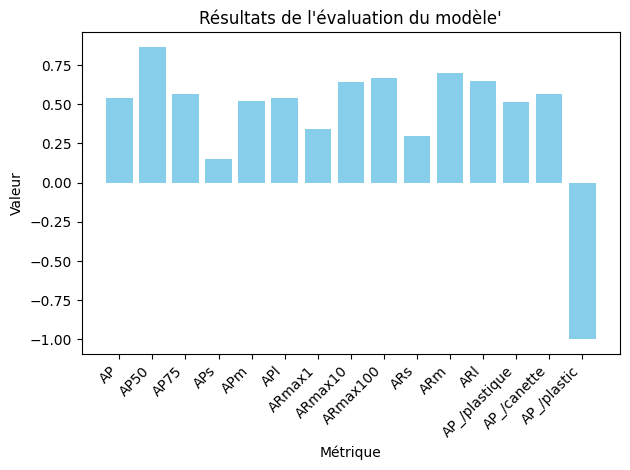

In [13]:
# https://cocodataset.org/#detection-eval
# val_loss, val_accuracy = model.evaluate(val_data)

evaluation = model.evaluate(val_data)

def plotEvaluation(eval, title="Résultats de l\'évaluation du modèle'"):
    import matplotlib.pyplot as plt
    plt.bar(eval.keys(), eval.values(), color='skyblue')
    plt.xlabel('Métrique')
    plt.ylabel('Valeur')
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

plotEvaluation(evaluation)

## Export du modèle au format Tensorflow lite

In [21]:
config = QuantizationConfig.for_float16()
model.export(export_dir='bin/', 
             tflite_filename='greengardians-full-v2.tflite',
             )
# model.export(export_dir='bin/', 
#              quantization_config=config,
#              export_format=[ExportFormat.SAVED_MODEL, ExportFormat.LABEL])


2024-04-16 13:44:11.019756: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'resample_p7/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.
2024-04-16 13:44:35.313628: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2024-04-16 13:44:35.313699: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2024-04-16 13:44:35.314028: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpxyeo6bke
2024-04-16 13:44:35.465584: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2024-04-16 13:44:35.465623: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpxyeo6bke
2024-04-16 13:44:36.273668: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2024-04-16 13:44:42.952076: I tensorflow/cc/saved_

Estimated count of arithmetic ops: 13.717 G  ops, equivalently 6.859 G  MACs


## Evaluation du modèle entrainé

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


16/16 [==============================] - 272s 17s/step



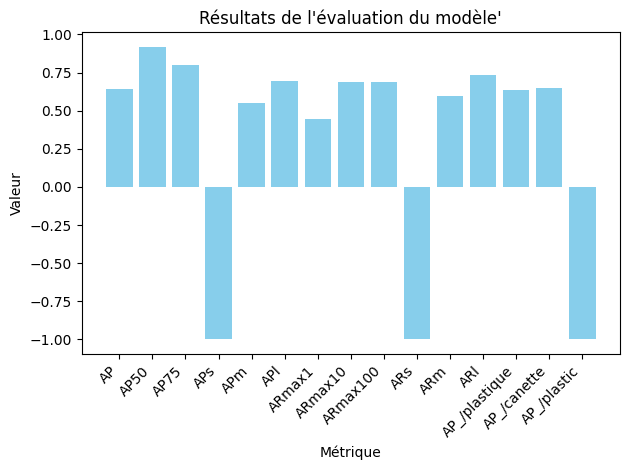

In [15]:
model_path = 'bin/greengardians.tflite'
evaluation_lite = model.evaluate_tflite(model_path, test_data)

plotEvaluation(evaluation_lite)

In [16]:
# NUMBER_OF_TPUS =  2

# !edgetpu_compiler 'bin/greengardians-full.tflite' --num_segments=$NUMBER_OF_TPUS

## Utilitaires

In [17]:
import cv2

from PIL import Image

# Load the labels into a list
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# classes = {0: "plastique", 1: "canette"}
print('classes', classes)

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)


  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])


  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results

def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  print('results', results)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

classes ['plastique', 'canette', 'plastic']


## Prediction

In [18]:
# Load the TFLite model
import os, random
from pathlib import Path
model_path = 'bin/greengardians.tflite'

interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# # Run inference and draw detection result on the local copy of the original file
DETECTION_THRESHOLD = 0.5
          
PROJECT_FOLDER = Path(Path.cwd())
image_folder = str(PROJECT_FOLDER) + '/datasets/dataset.voc/test/'
# imageToPredict = 'datasets/dataset.voc/test/IMG_20231025_095509_jpg.rf.c83cb3628dda974ef28a37ce404b9ab7.jpg'
                                                          
l_detection_result_image = []
files = [image_folder +'/'+ f for f in os.listdir(image_folder) if f.endswith('.jpg')]

# imageToPredict = 'datasets/dataset.voc/test/IMG_20231025_095509_jpg.rf.c83cb3628dda974ef28a37ce404b9ab7.jpg'
imageToPredict = random.choice(files)
print(imageToPredict)
detection_result_image = run_odt_and_draw_results(
        imageToPredict,
        interpreter,
        threshold=DETECTION_THRESHOLD
)
# for file in files:
#     detection_result_image = run_odt_and_draw_results(
#         file,
#         interpreter,
#         threshold=DETECTION_THRESHOLD
#     )
#     l_detection_result_image.append(detection_result_image)

/home/charles/web/alyra/villepropre/vp-server/train/datasets/dataset.voc/test//IMG_20231025_095258_jpg.rf.4fefc8f385ce0cc9867dc873007fdfc5.jpg
results [{'bounding_box': array([0.30383074, 0.3973522 , 0.57661545, 0.5024469 ], dtype=float32), 'class_id': 1.0, 'score': 0.8203125}]


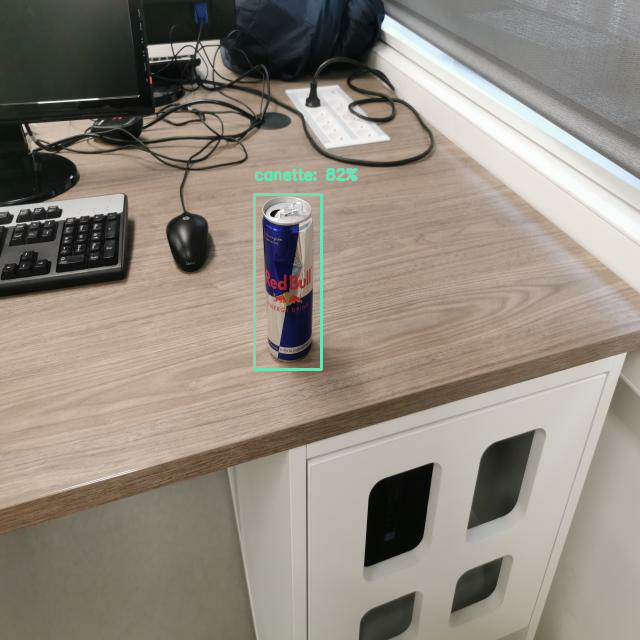

In [19]:
Image.fromarray(detection_result_image)

# import matplotlib.pyplot as plt
# plt.figure(figsize=(5, 5))
# plt.imshow(imageToPredict)
# plt.show()
# plt.close()
# test_validation_folder = str(PROJECT_FOLDER) + '/datasets/dataset.voc/test_val/'

# # Show all the detection result
# for image in l_detection_result_image:
#     plt.figure(figsize=(5, 5))
#     plt.imshow(image)
#     plt.show()
#     # Save the image in the validation folder    
#     plt.close()